In [37]:
import json
import os
import pandas as pd


def load_data(file_path):
    """
    Load data from a JSON file.
    
    :param file_path: Path to the JSON file.
    :return: Parsed JSON data.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def get_results(data):
    results = {entry['id']: entry['response'] for entry in data}
    return results

def get_tokens(data):
    tokens = dict()
    for entry in data:
        if not isinstance(entry["tokens"], dict):
            tokens[entry['id']] = entry['tokens']
        else:
            tokens[entry['id']] = entry['tokens'].get('total_tokens', 0)
    return tokens

def get_gt(data):
    gt = {entry['id']: entry['is_blooming'] for entry in data}
    return gt

dfs = []
for file in os.listdir("results"):
    if file.endswith("850.json"):
        with open(os.path.join("results", file), 'r') as f:
            data = json.load(f)
        results = get_results(data)
        tokens = get_tokens(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(results, orient='index', columns=[name]))

for file in os.listdir("ground_truth"):
    if "850" in file and file.endswith(".json"):
        with open(os.path.join("ground_truth", file), 'r') as f:
            data = json.load(f)
        gt = get_gt(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(gt, orient='index', columns=[name]))

df = pd.concat(dfs, axis=1)
df.rename(columns={
    df.columns[0]: "LLM only",
    df.columns[1]: "Single Agent + Data",
    df.columns[2]: "Multi Agent + Data",
    df.columns[3]: "Apfel Agent",
    df.columns[4]: "Birke Agent",
    df.columns[5]: "Erle Agent",
    df.columns[6]: "Hasel Agent",
    df.columns[7]: "Winterraps Agent",
    df.columns[8]: "Winterroggen Agent",
    df.columns[9]: "Esche Agent",
    df.columns[10]: "Forsythie Agent",
    df.columns[11]: "Huflattich Agent",
    df.columns[12]: "Loewenzahn Agent",
    df.columns[13]: "Schneegloeckchen Agent",
    df.columns[14]: "Beifuss Agent",
    df.columns[15]: "Ground Truth Dev 0",
    df.columns[16]: "Ground Truth Dev 5",
    df.columns[17]: "Ground Truth Dev 10"
}, inplace=True)

In [38]:
df = df.iloc[:-250, :]
df

,LLM only,Single Agent + Data,Multi Agent + Data,Apfel Agent,Birke Agent,Erle Agent,Hasel Agent,Winterraps Agent,Winterroggen Agent,Esche Agent,Forsythie Agent,Huflattich Agent,Loewenzahn Agent,Schneegloeckchen Agent,Beifuss Agent,Ground Truth Dev 0,Ground Truth Dev 5,Ground Truth Dev 10
0,no answer,no,no,no,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no,yes,yes
1,yes,yes,yes,yes,no answer,yes,yes,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,yes,yes,yes
2,yes,no,no,no,no answer,yes,no answer,no answer,no,no answer,no answer,no answer,no answer,no answer,no answer,no,yes,yes
3,no,no,no,no,no answer,yes,no,no,no,no answer,no answer,no answer,no answer,no answer,no answer,no,no,no
4,no answer,no,no,no,no,yes,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,yes,no answer,no answer,no answer,no answer,no answer,yes,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no,no,no
596,no answer,no answer,no answer,no answer,no answer,yes,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,yes,yes,yes
597,no answer,no answer,no answer,no answer,no answer,no answer,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no,no,no
598,yes,no answer,no answer,yes,no,yes,yes,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,yes,yes,yes


In [43]:
df["Birke Agent"]

0      no answer
1      no answer
2      no answer
3      no answer
4             no
         ...    
595    no answer
596    no answer
597    no answer
598           no
599    no answer
Name: Birke Agent, Length: 600, dtype: object

In [40]:
df.iloc[:, -3].values

array(['no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no',
       'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no',
       'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no',
       'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes',
       'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no

In [ ]:
expect_answer = {
    "Apfel Agent": (0,49),
    "Birke Agent": (50,99),
    "Erle Agent": (100,149),
    "Hasel Agent": (150,199),
    "Winterraps Agent": (200,249),
    "Winterroggen Agent": (250,299),
}


def make_comparison_matrix(df, pos):
    comparison_matrix_0 = pd.DataFrame(
        {
            col: (df[col].values == df.iloc[:, pos].values) or df[col]
            for col in df.columns[:-3]
        }
    )
    return comparison_matrix_0

comparison_matrix_0 = make_comparison_matrix(df, -3)
comparison_matrix_5 = make_comparison_matrix(df, -2)
comparison_matrix_10 = make_comparison_matrix(df, -1)

,LLM only,Single Agent + Data,Multi Agent + Data,Apfel Agent,Birke Agent,Erle Agent,Hasel Agent,Winterraps Agent,Winterroggen Agent,Esche Agent,Forsythie Agent,Huflattich Agent,Loewenzahn Agent,Schneegloeckchen Agent,Beifuss Agent
0,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,False,True,True,True,False,False,False,False,False,False,False
2,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False
3,True,True,True,True,False,False,True,True,True,False,False,False,False,False,False
4,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
596,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
597,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
598,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False


In [42]:
df_heatmap = pd.concat([comparison_matrix_0.sum(axis=0)/len(comparison_matrix_0), 
 comparison_matrix_5.sum(axis=0)/len(comparison_matrix_5), 
 comparison_matrix_10.sum(axis=0)/len(comparison_matrix_10)], axis=1)
df_heatmap.columns = ['0', '5', '10']
df_heatmap

,0,5,10
LLM only,0.530000,0.536667,0.538333
Single Agent + Data,0.476667,0.456667,0.450000
Multi Agent + Data,0.463333,0.443333,0.436667
Apfel Agent,0.375000,0.351667,0.346667
Birke Agent,0.238333,0.235000,0.233333
Erle Agent,0.420000,0.426667,0.430000
Hasel Agent,0.535000,0.535000,0.535000
Winterraps Agent,0.315000,0.306667,0.301667
Winterroggen Agent,0.306667,0.293333,0.291667
Esche Agent,0.001667,0.001667,0.001667


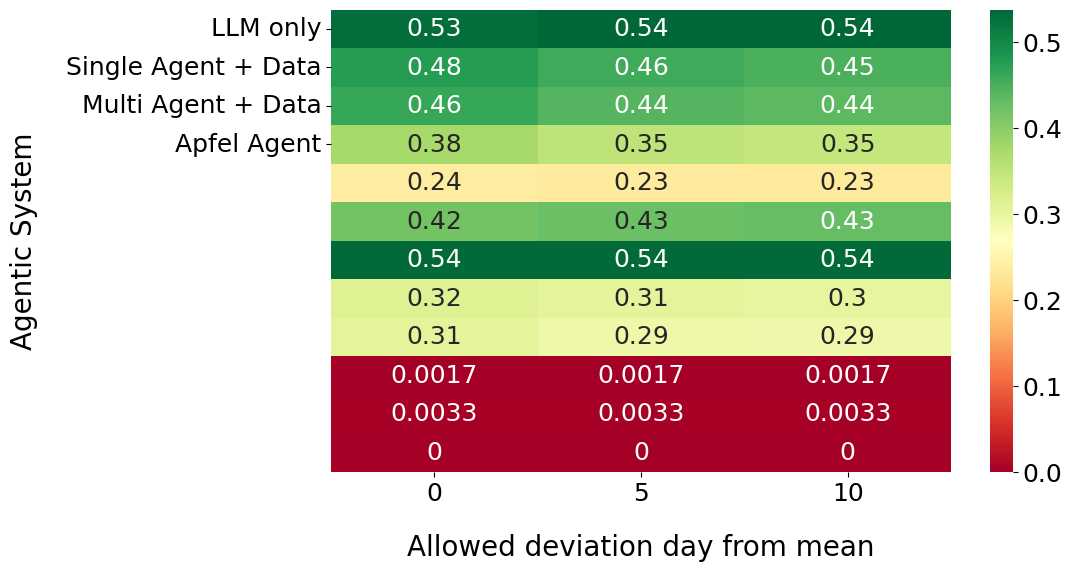

In [44]:



import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap[0:12], annot=True, cmap="RdYlGn", xticklabels=df_heatmap.columns[:4], yticklabels=df_heatmap.index[:4])
#plt.title("Comparison Heatmap: Predictions vs Ground Truth")
plt.xlabel("Allowed deviation day from mean", fontsize=20,labelpad=20)
plt.ylabel("Agentic System", fontsize=20, labelpad=20)
plt.show()

In [57]:
cm = comparison_matrix_10
cm = cm.groupby(cm.index // 50).sum()/50
cm.index = ["Apfel", "Birke", "Erle", "Hasel", "Winterraps", "Winterroggen", "Esche", "Forsythie", "Huflattich", "Loewenzahn", "Schneegloeckchen", "Beifuss"]
cm = cm.transpose()
cm = cm.iloc[:8, :5]

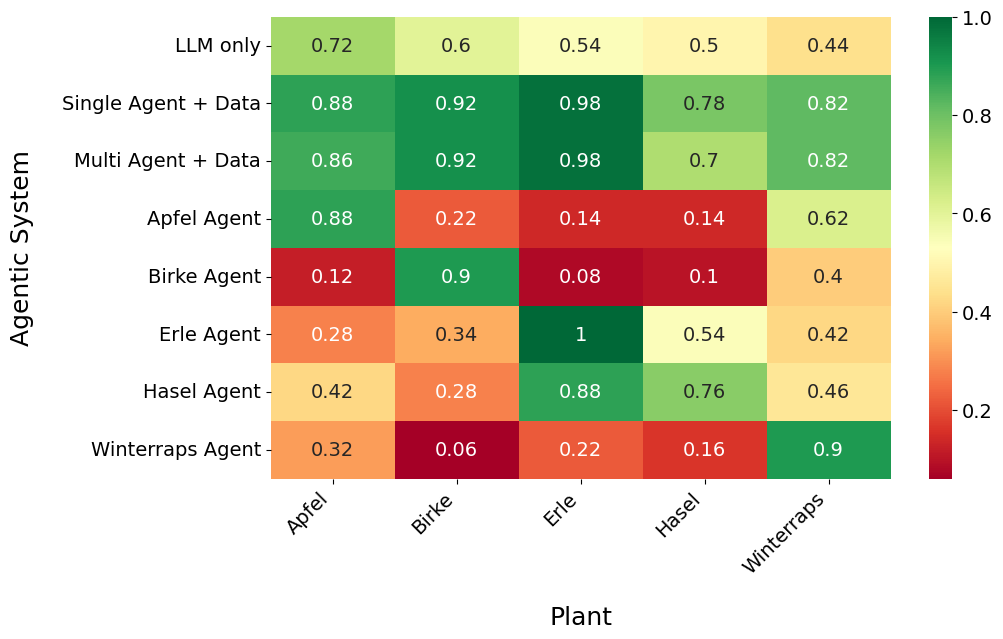

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap="RdYlGn", xticklabels=cm.columns, yticklabels=cm.index)
#plt.title("Comparison Heatmap: Predictions vs Ground Truth")
plt.xlabel("Plant", fontsize=18, labelpad=20)
plt.ylabel("Agentic System", fontsize=18, labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.show()

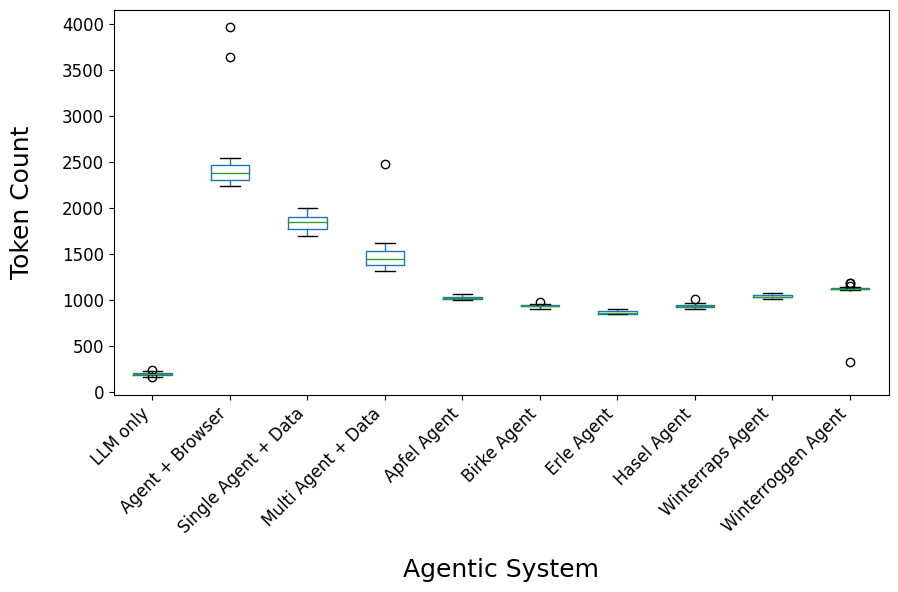

In [9]:
import matplotlib.pyplot as plt
#token usage
plt.rcParams.update({'font.size': 12})

dfs = []
for file in os.listdir("results"):
    if file.endswith(".json"):
        with open(os.path.join("results", file), 'r') as f:
            data = json.load(f)
        tokens = get_tokens(data)
        name = os.path.splitext(file)[0]
        dfs.append(pd.DataFrame.from_dict(tokens, orient='index', columns=[name]))

df = pd.concat(dfs, axis=1)
df.rename(columns={
    df.columns[0]: "LLM only",
    df.columns[1]: "Agent + Browser",
    df.columns[2]: "Single Agent + Data",
    df.columns[3]: "Multi Agent + Data",
    df.columns[4]: "Apfel Agent",
    df.columns[5]: "Birke Agent",
    df.columns[6]: "Erle Agent",
    df.columns[7]: "Hasel Agent",
    df.columns[8]: "Winterraps Agent",
    df.columns[9]: "Winterroggen Agent"
}, inplace=True)
df.boxplot(rot=90, figsize=(10, 5), grid=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Token Count", fontsize=18, labelpad=20)
plt.xlabel("Agentic System", fontsize=18, labelpad=15)
plt.show()


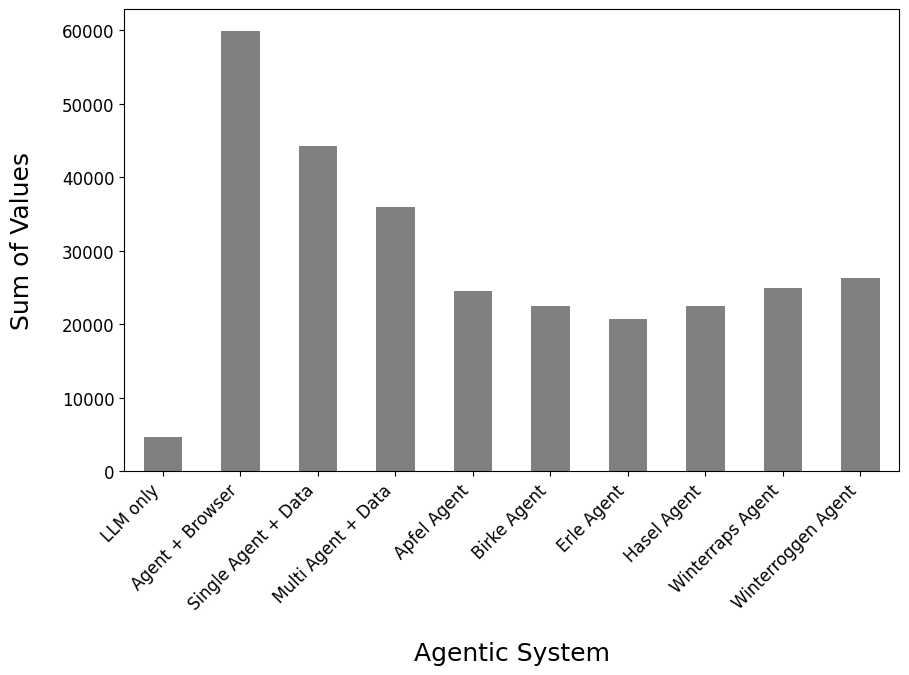

In [11]:


df.sum(axis=0).plot(kind='bar', figsize=(10, 6), color='grey')
plt.xlabel("Agentic System", fontsize=18, labelpad=20)
plt.ylabel("Sum of Values", fontsize=18, labelpad=20)
#plt.title("Sum of Values per Agentic System", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()